In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 폰트 설정을 위한 코드 (이미 설정하셨다면 생략)
plt.rc('font', family='Malgun Gothic') # Windows
# plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [3]:
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# 데이터 준비

In [77]:
df = pd.read_csv('C:/Users/sopi0/codes/korea-tour-recommender/data/2024_8차_전처리.csv')
df.head()

,아이디,연령별,한국 방문횟수(카테고리),문3-2. 고려한 관광인프라_1,여행동반자_그룹,방문 지역 수,여행 패턴,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측,문3-1. 고려한 관광활동_1순위,문1-1. 한국여행 관심 계기_1순위
0,57,5,4,안전 및 퀄리티,가족형,1,서울 심층형,451.666667,6.0,도시 소비형,K-컬처형
1,58,4,4,여행 편의성,가족형,1,서울 단기형,272.935000,5.0,경험형,K-컬처형
2,59,3,3,여행 편의성,단체형,1,서울 심층형,177.650000,6.0,특수 목적,K-컬처형
3,60,2,1,여행 편의성,혼자형,1,서울 심층형,153.780000,6.0,경험형,K-컬처형
4,61,2,4,가성비,가족형,2,서울 단기형,329.460000,5.0,도시 소비형,경험 및 관계


# 실험1) '총 체재기간' 제외

## 1. 데이터 전처리 (Data Preprocessing)

### 데이터 타입 변경(범주형, 수치형)

In [78]:
# 분석에 불필요한 변수 제거
cluster_data = df.drop(columns=['아이디','문9-3. 총 체재기간_61일 이상 결측']).copy()

# # [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# # Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
# categorical_cols_int = ['성별']
# for col in categorical_cols_int:
#     cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

< 분석 대상 변수 타입 확인 >
연령별                                        int64
한국 방문횟수(카테고리)                              int64
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
여행 패턴                                     object
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문3-1. 고려한 관광활동_1순위                        object
문1-1. 한국여행 관심 계기_1순위                      object
dtype: object
--------------------------------------------------


### 수치형 로그변환

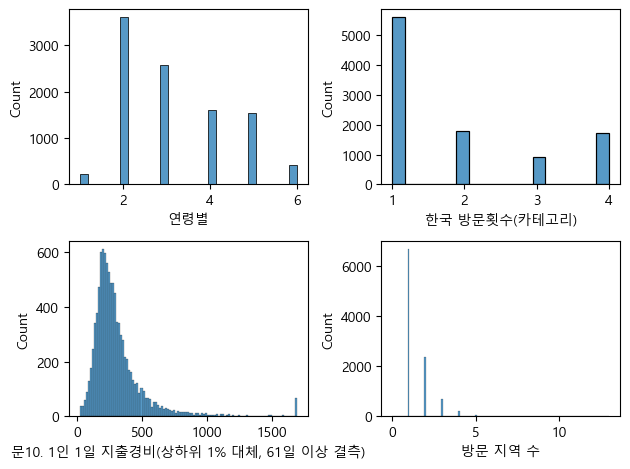

In [79]:
num_cols = ['연령별', '한국 방문횟수(카테고리)', 
            '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '방문 지역 수']
fig, ax = plt.subplots(2, 2)
for i in range(4):
    sns.histplot(data=df[num_cols], x = num_cols[i], ax=ax[i//2, i%2])
    
plt.tight_layout()
plt.show()

In [80]:
# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)'
    #'문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.


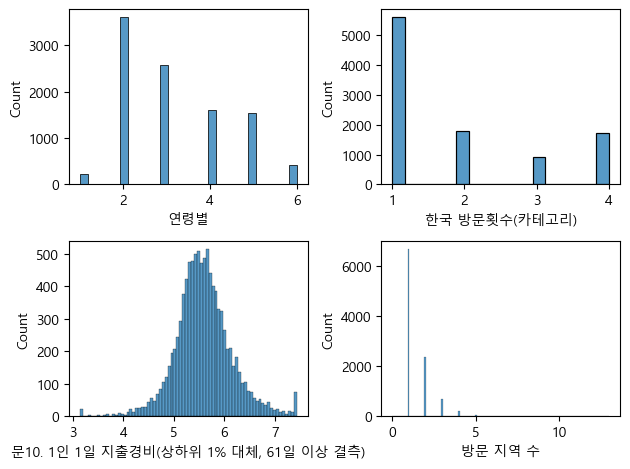

In [81]:
num_cols = ['연령별', '한국 방문횟수(카테고리)', 
            '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '방문 지역 수']
fig, ax = plt.subplots(2, 2)
for i in range(4):
    sns.histplot(data=cluster_data_transformed[num_cols], x = num_cols[i], ax=ax[i//2, i%2])
    
plt.tight_layout()
plt.show()

## 2. Gower Distance Matrix 계산

In [82]:
print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10003, 10003)
   -> 메모리 점유율(약): 381.70 MB


## 3. 계층적 군집화 (Hierarchical Clustering)

In [83]:
print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


## 4. 덴드로그램 시각화 및 최적의 k 찾기

c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


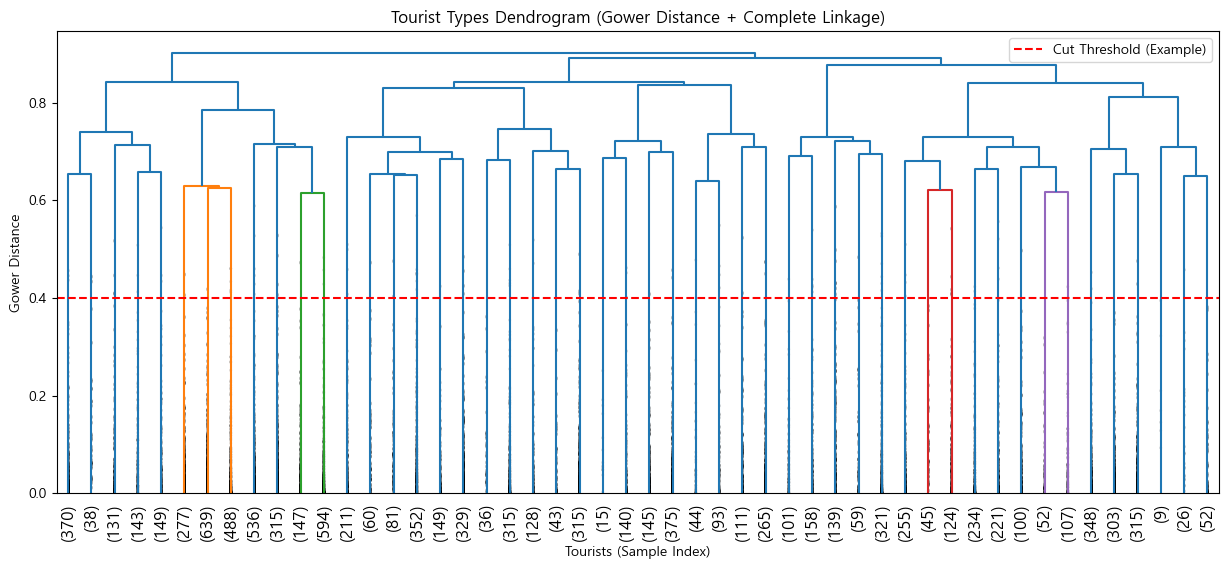

In [98]:
plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

Z1 = Z.copy()
# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z1,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

## 5. 최종 군집 할당 및 페르소나 정의

In [85]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 6

# 군집 라벨 생성
labels1 = fcluster(Z1, k_final, criterion='maxclust')
result1 = df.copy()
result1['Cluster'] = labels1 # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    '연령별': 'mean',
    '한국 방문횟수(카테고리)': 'mean',
    '문1-1. 한국여행 관심 계기_1순위': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode,
    '여행 패턴': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = result1.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = result1['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)


< 군집별 특성 요약 (k=6) >


Cluster,1,2,3,4,5,6
방문 지역 수,1.799037,1.512016,1.239227,1.399832,1.394602,1.621634
"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",277.9162,314.248287,368.497016,332.790365,299.002668,279.249364
연령별,2.914561,3.116822,3.304111,3.505051,3.254499,3.100411
한국 방문횟수(카테고리),1.722022,1.883511,2.094601,2.159933,1.874036,1.561387
문1-1. 한국여행 관심 계기_1순위,K-컬처형,K-컬처형,가성비 및 접근성,K-컬처형,경험 및 관계,경험 및 관계
문3-2. 고려한 관광인프라_1,여행 편의성,여행 편의성,안전 및 퀄리티,안전 및 퀄리티,가성비,여행 편의성
여행동반자_그룹,가족형,가족형,가족형,가족형,친구형,가족형
문3-1. 고려한 관광활동_1순위,"역사, 전통, 자연",도시 소비형,도시 소비형,도시 소비형,도시 소비형,"역사, 전통, 자연"
여행 패턴,서울 심층형,서울 심층형,서울 단기형,서울 단기형,서울 단기형,수도권/지방형(탐험가형)
Count,831,2996,2019,1188,778,2191


In [86]:
df.columns

Index(['아이디', '연령별', '한국 방문횟수(카테고리)', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
       '방문 지역 수', '여행 패턴', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
       '문9-3. 총 체재기간_61일 이상 결측', '문3-1. 고려한 관광활동_1순위', '문1-1. 한국여행 관심 계기_1순위'],
      dtype='object')

In [87]:
num_cols = ['연령별', '방문 지역 수', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
            '한국 방문횟수(카테고리)']
cat_cols = ['문1-1. 한국여행 관심 계기_1순위', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
            '문3-1. 고려한 관광활동_1순위', '여행 패턴']

In [89]:
result1['Cluster'].unique()

array([4, 2, 5, 3, 6, 1])

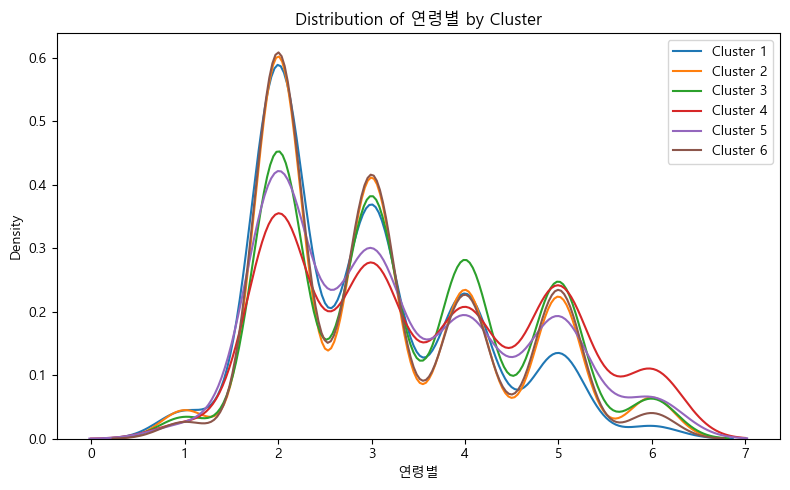

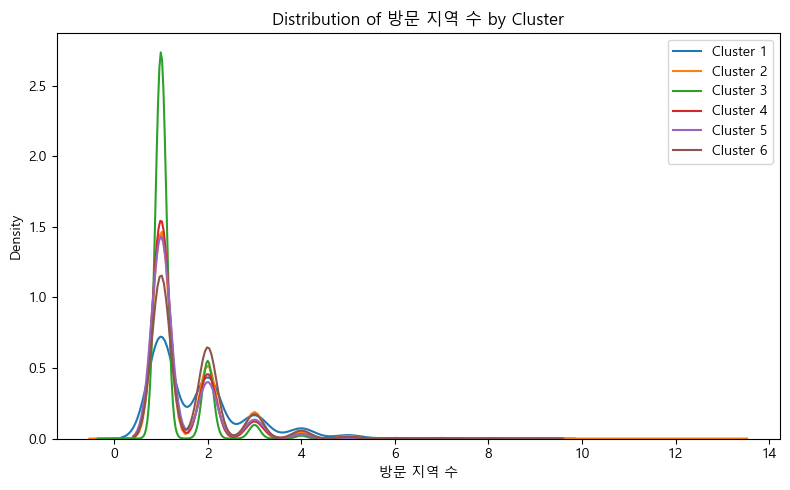

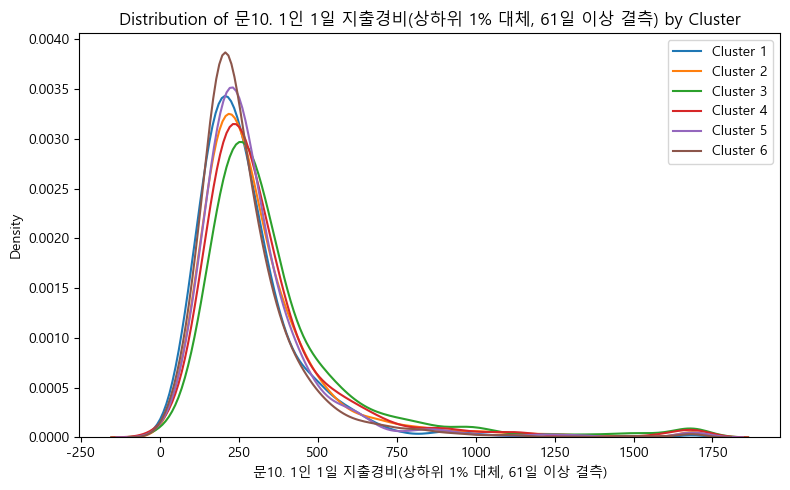

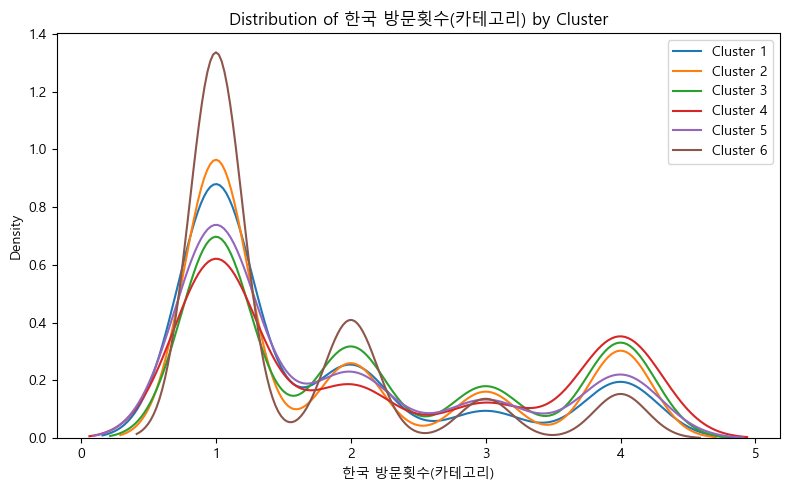

In [91]:
clusters = sorted(result1['Cluster'].unique())
for col in num_cols:
    plt.figure(figsize=(8, 5))
    
    for c in clusters:
        sns.kdeplot(
        result1[result1['Cluster'] == c][col],
        label=f'Cluster {c}',
        fill=False
        )
    plt.title(f'Distribution of {col} by Cluster')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

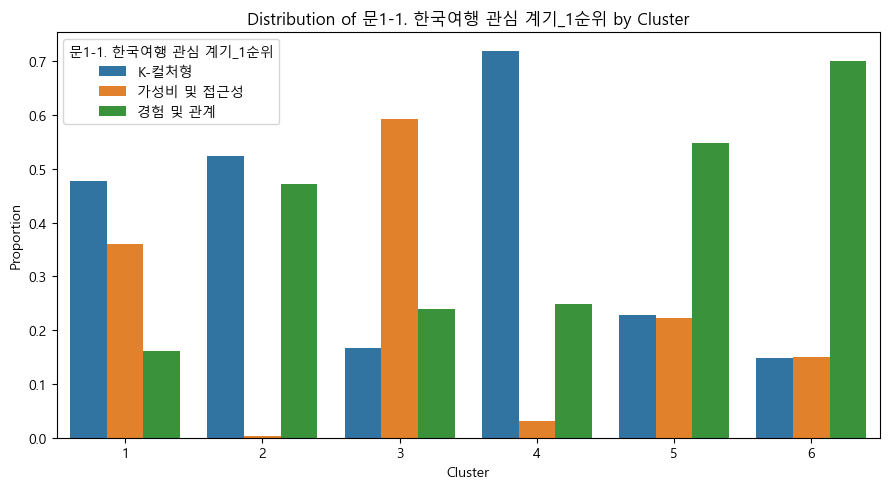

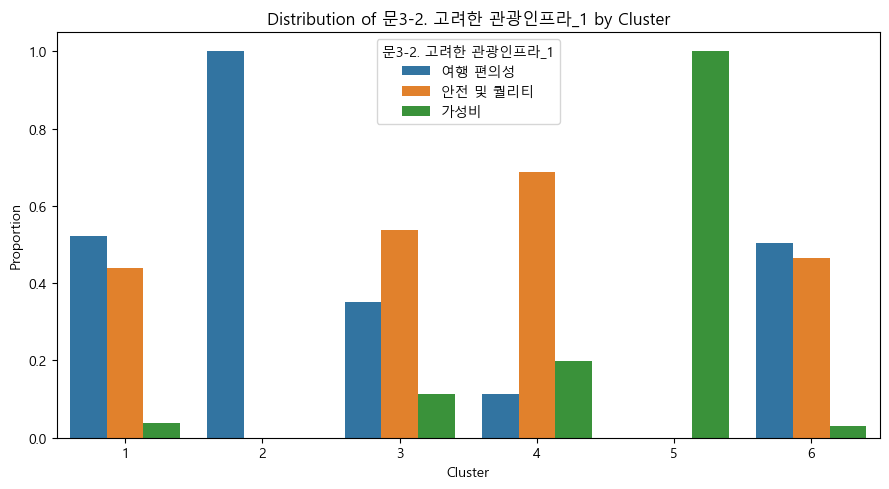

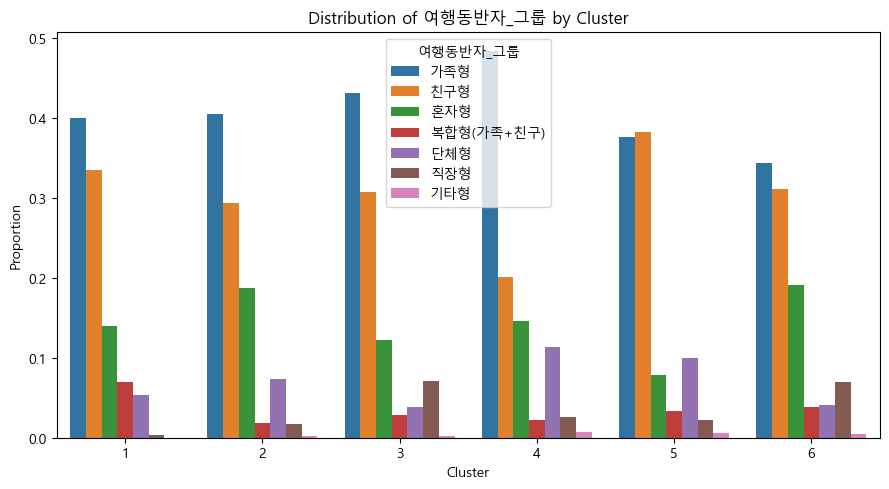

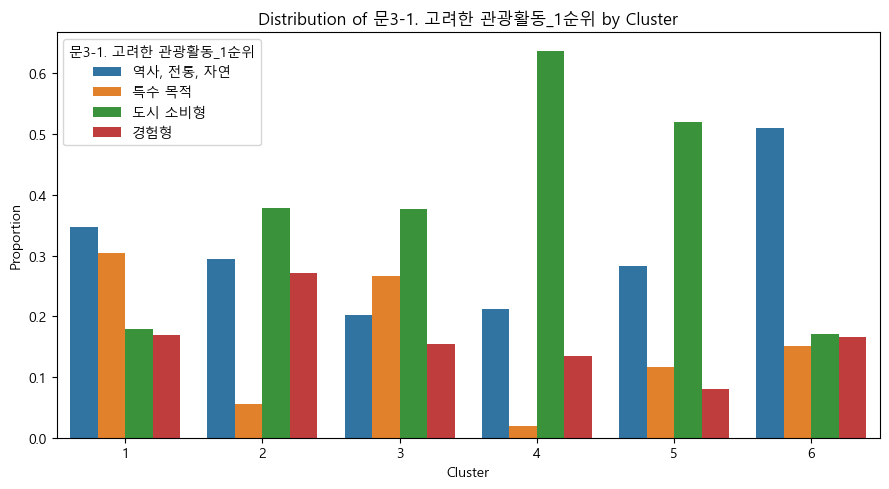

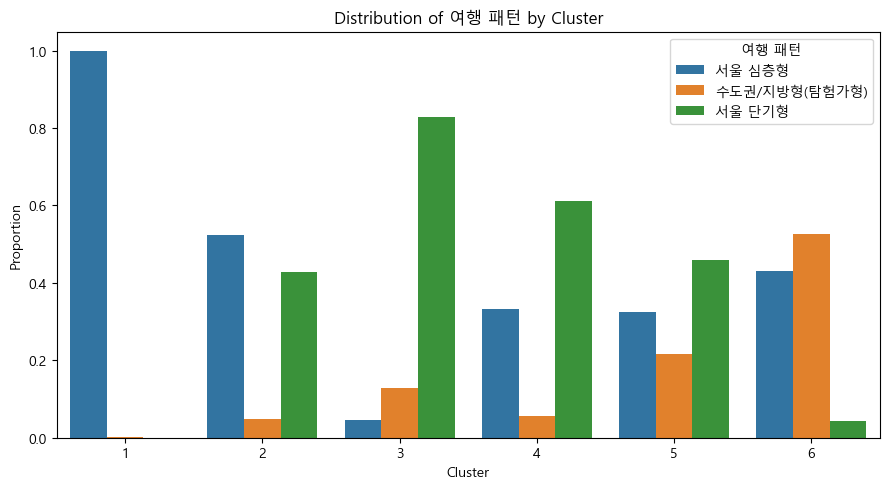

In [93]:
for col in cat_cols:
    prop_df = (
        result1
        .groupby('Cluster')[col]
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
        )
    plt.figure(figsize=(9, 5))
    sns.barplot(
        data=prop_df,
        x='Cluster',
        y='proportion',
        hue=col
        )
    plt.title(f'Distribution of {col} by Cluster')
    plt.ylabel('Proportion')
    plt.tight_layout()
    plt.show()

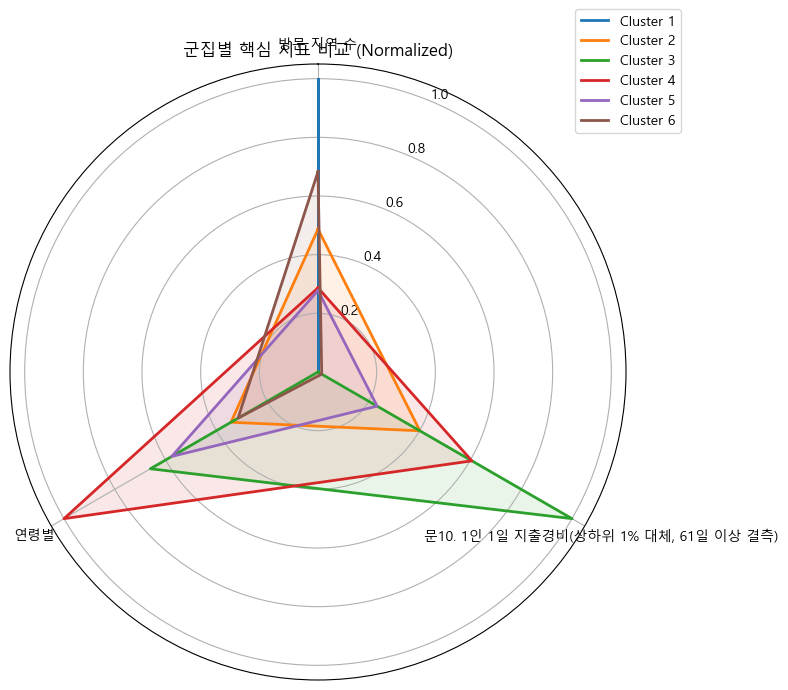

In [96]:
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_radar(summary_df):
    # 수치형 지표만 선택 (연령, 지출, 체재기간 등)
    radar_cols = ['방문 지역 수', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', 
                  #'문9-3. 총 체재기간_61일 이상 결측', 
                  '연령별']
    
    scaler = MinMaxScaler()
    radar_data = scaler.fit_transform(summary_df[radar_cols])
    radar_df = pd.DataFrame(radar_data, columns=radar_cols, index=summary_df.index)
    
    labels = radar_cols
    num_vars = len(labels)
    
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for i in range(len(radar_df)):
        values = radar_df.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=f'Cluster {radar_df.index[i]}')
        ax.fill(angles, values, alpha=0.1)
        
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title('군집별 핵심 지표 비교 (Normalized)')
    plt.show()

# summary_df (평균값 기준)를 넣어서 실행
plot_cluster_radar(summary_df)

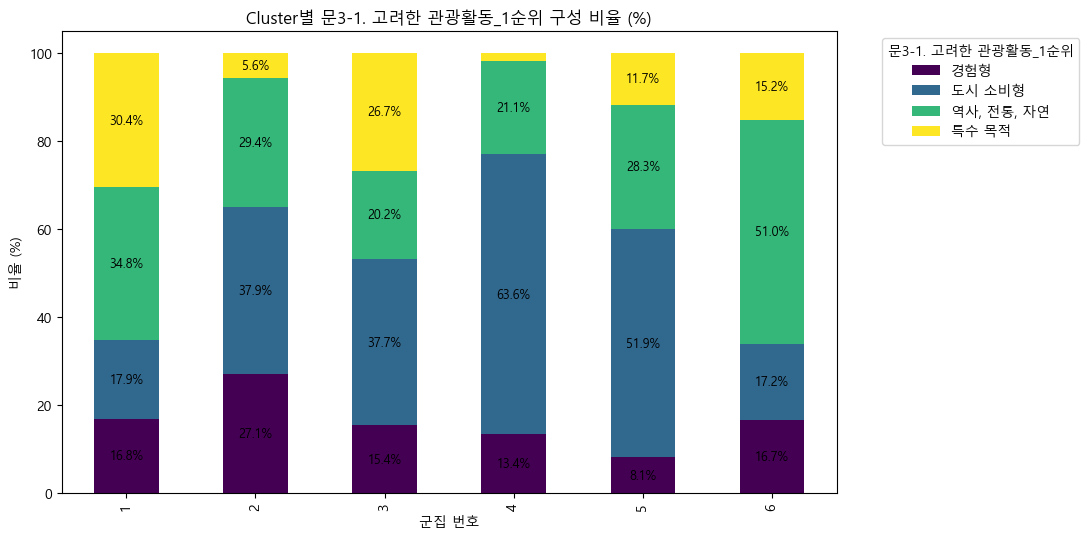

In [99]:
def plot_cluster_categorical_proportions(df, cat_col):
    # 군집별 범주 비율 계산
    ct = pd.crosstab(df['Cluster'], df[cat_col], normalize='index') * 100
    
    ax = ct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title(f'Cluster별 {cat_col} 구성 비율 (%)')
    plt.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('비율 (%)')
    plt.xlabel('군집 번호')
    
    # 막대 안에 숫자 표시 (선택 사항)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 5: # 5% 이상의 비중만 표시
            x, y = p.get_xy() 
            ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center', fontsize=9)
            
    plt.show()

# 사용 예시: 관광활동이나 관심 계기 확인
plot_cluster_categorical_proportions(result1, '문3-1. 고려한 관광활동_1순위')

In [102]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

def plot_radar_chart(summary_df):
    # 스케일이 다른 수치들을 0~1로 변환하여 시각화 비교 용이하게 함
    scaler = MinMaxScaler()
    num_cols = ['방문 지역 수', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', 
                #'문9-3. 총 체재기간_61일 이상 결측', 
                '연령별', '한국 방문횟수(카테고리)']
    
    df_scaled = pd.DataFrame(scaler.fit_transform(summary_df[num_cols]), 
                             columns=num_cols, index=summary_df.index)

    fig = go.Figure()

    for i in df_scaled.index:
        fig.add_trace(go.Scatterpolar(
            r=df_scaled.loc[i].values,
            theta=num_cols,
            fill='toself',
            name=f'Cluster {i}'
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=True,
        title="군집별 수치형 지표 상대 비교 (Radar Chart)"
    )
    fig.show()

# summary_df는 요약표 데이터프레임입니다.
plot_radar_chart(summary_df)

In [105]:
import plotly.express as px

def plot_sunburst(df, target_col):
    # df: 클러스터 결과가 포함된 원본 데이터프레임
    fig = px.sunburst(df, path=['Cluster', target_col], 
                      values='방문 지역 수', # 단순히 빈도 계산을 위해 사용
                      color='Cluster',
                      title=f"군집별 {target_col} 구성 비중")
    fig.show()

# 예: 군집별 관광활동 선호도 확인
plot_sunburst(result1, '문3-1. 고려한 관광활동_1순위')

# 실험 2) '한국 방문횟수' 제외

In [47]:
df.columns

Index(['아이디', '연령별', '한국 방문횟수(카테고리)', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
       '방문 지역 수', '여행 패턴', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
       '문9-3. 총 체재기간_61일 이상 결측', '문3-1. 고려한 관광활동_1순위', '문1-1. 한국여행 관심 계기_1순위',
       'Cluster'],
      dtype='object')

< 분석 대상 변수 타입 확인 >
연령별                                        int64
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
여행 패턴                                     object
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문9-3. 총 체재기간_61일 이상 결측                   float64
문3-1. 고려한 관광활동_1순위                        object
문1-1. 한국여행 관심 계기_1순위                      object
dtype: object
--------------------------------------------------
로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.
1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10003, 10003)
   -> 메모리 점유율(약): 381.70 MB
2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


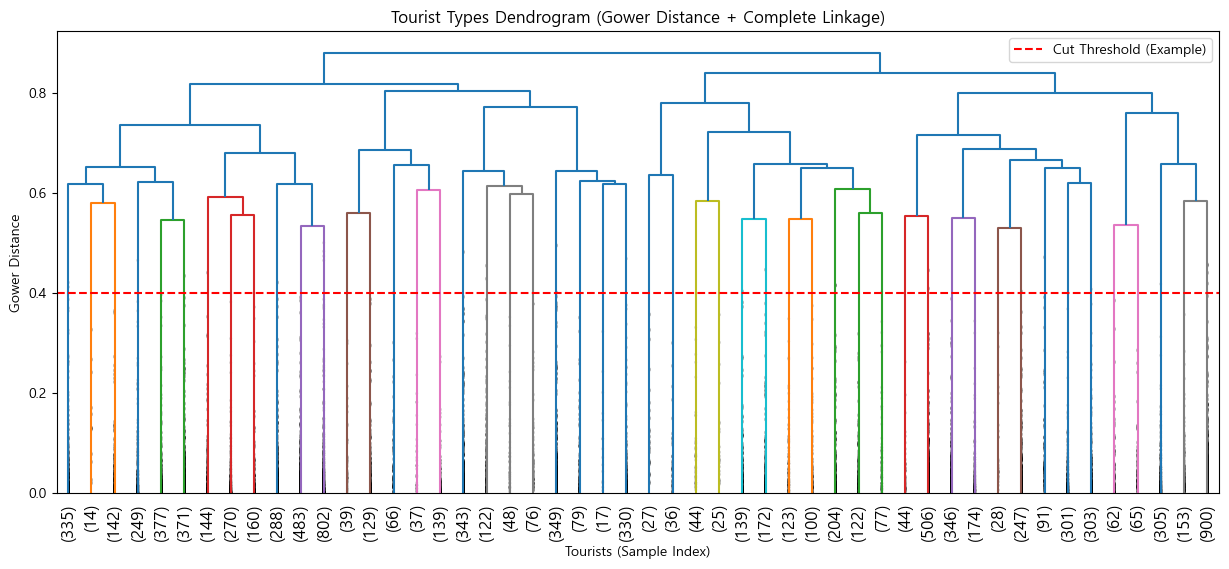

In [48]:
# 분석에 불필요한 변수 제거
cluster_data = df.drop(columns=['아이디','한국 방문횟수(카테고리)','Cluster']).copy()

# # [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# # Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
# categorical_cols_int = ['성별']
# for col in categorical_cols_int:
#     cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
    '문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z2 = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z2,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

In [ ]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 5

# 군집 라벨 생성
labels2 = fcluster(Z2, k_final, criterion='maxclust')
result2 = df.copy()
result2['Cluster'] = labels2 # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    '문9-3. 총 체재기간_61일 이상 결측': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    '연령별': get_mode,
    #'한국 방문횟수(카테고리)': get_mode,
    '문1-1. 한국여행 관심 계기_1순위': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode,
    '여행 패턴': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = result2.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = result2['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)


< 군집별 특성 요약 (k=5) >


Cluster,1,2,3,4,5
방문 지역 수,1.222834,1.421951,1.390029,1.500468,1.787234
"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",368.237155,297.292706,294.980765,262.770727,287.250596
문9-3. 총 체재기간_61일 이상 결측,4.141678,5.360976,6.264663,6.418148,9.443404
연령별,2,2,2,2,2
문1-1. 한국여행 관심 계기_1순위,K-컬처형,경험 및 관계,가성비 및 접근성,경험 및 관계,경험 및 관계
문3-2. 고려한 관광인프라_1,여행 편의성,안전 및 퀄리티,가성비,여행 편의성,여행 편의성
여행동반자_그룹,가족형,친구형,가족형,가족형,가족형
문3-1. 고려한 관광활동_1순위,도시 소비형,도시 소비형,도시 소비형,"역사, 전통, 자연","역사, 전통, 자연"
여행 패턴,서울 단기형,수도권/지방형(탐험가형),서울 심층형,수도권/지방형(탐험가형),서울 심층형
Count,3635,410,1364,1069,3525


# 실험 3) '총 체재기간', '한국 방문횟수' 제외

In [25]:
df.columns

Index(['아이디', '연령별', '한국 방문횟수(카테고리)', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
       '방문 지역 수', '여행 패턴', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
       '문9-3. 총 체재기간_61일 이상 결측', '문3-1. 고려한 관광활동_1순위', '문1-1. 한국여행 관심 계기_1순위'],
      dtype='object')

< 분석 대상 변수 타입 확인 >
연령별                                        int64
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
여행 패턴                                     object
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문3-1. 고려한 관광활동_1순위                        object
문1-1. 한국여행 관심 계기_1순위                      object
dtype: object
--------------------------------------------------
로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.
1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10003, 10003)
   -> 메모리 점유율(약): 381.70 MB
2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


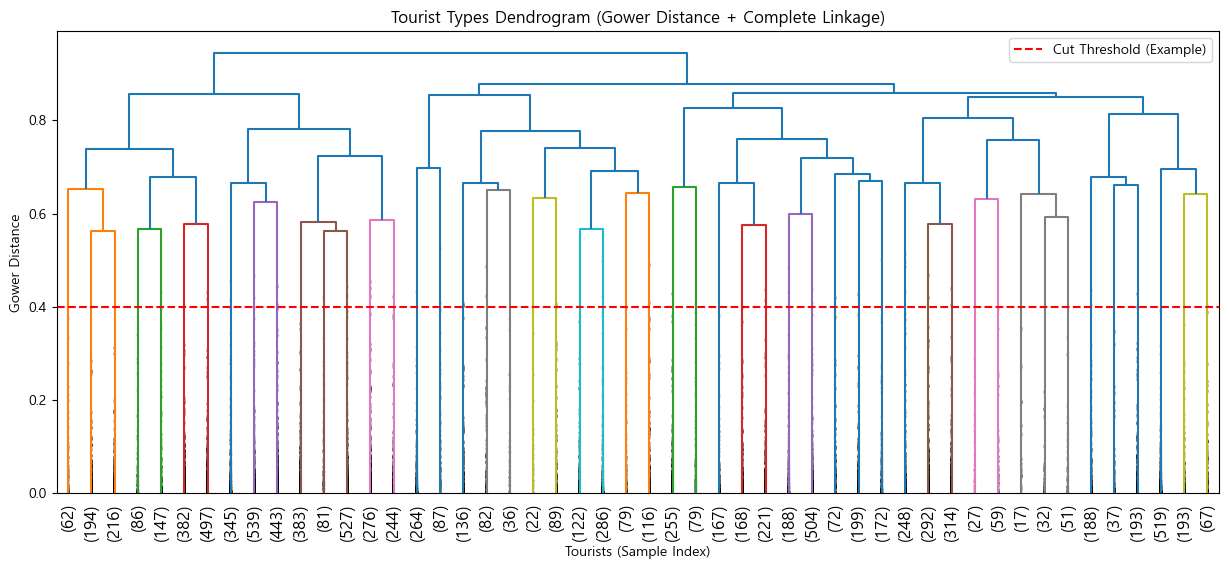

In [50]:
# 분석에 불필요한 변수 제거
cluster_data = df.drop(columns=['아이디','한국 방문횟수(카테고리)','문9-3. 총 체재기간_61일 이상 결측', 'Cluster']).copy()

# # [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# # Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
# categorical_cols_int = ['성별']
# for col in categorical_cols_int:
#     cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
    #'문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z3 = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z3,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

In [51]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 8

# 군집 라벨 생성
labels3 = fcluster(Z3, k_final, criterion='maxclust')
result3 = df.copy()
result3['Cluster'] = labels3 # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    #'문9-3. 총 체재기간_61일 이상 결측': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    '연령별': get_mode,
    #'한국 방문횟수(카테고리)': get_mode,
    '문1-1. 한국여행 관심 계기_1순위': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode,
    '여행 패턴': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = result3.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = result3['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)


< 군집별 특성 요약 (k=8) >


Cluster,1,2,3,4,5,6,7,8
방문 지역 수,1.609848,1.418252,1.666667,1.234504,1.416168,1.269663,1.675,1.763576
"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",302.156827,323.30514,290.322113,305.320559,294.872235,368.419625,312.150746,264.423255
연령별,2,2,2,2,2,2,2,2
문1-1. 한국여행 관심 계기_1순위,K-컬처형,경험 및 관계,경험 및 관계,K-컬처형,가성비 및 접근성,K-컬처형,경험 및 관계,경험 및 관계
문3-2. 고려한 관광인프라_1,여행 편의성,여행 편의성,여행 편의성,가성비,안전 및 퀄리티,안전 및 퀄리티,안전 및 퀄리티,안전 및 퀄리티
여행동반자_그룹,친구형,가족형,친구형,친구형,가족형,가족형,가족형,가족형
문3-1. 고려한 관광활동_1순위,도시 소비형,도시 소비형,특수 목적,도시 소비형,도시 소비형,도시 소비형,경험형,"역사, 전통, 자연"
여행 패턴,서울 심층형,서울 단기형,서울 심층형,서울 단기형,수도권/지방형(탐험가형),서울 단기형,서울 심층형,수도권/지방형(탐험가형)
Count,1584,2838,351,968,334,1691,1040,1197


# 실험 4) '총 체재기간', '한국여행 관심 계기' 제외

In [30]:
df.columns

Index(['아이디', '연령별', '한국 방문횟수(카테고리)', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
       '방문 지역 수', '여행 패턴', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
       '문9-3. 총 체재기간_61일 이상 결측', '문3-1. 고려한 관광활동_1순위', '문1-1. 한국여행 관심 계기_1순위'],
      dtype='object')

< 분석 대상 변수 타입 확인 >
연령별                                        int64
한국 방문횟수(카테고리)                              int64
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
여행 패턴                                     object
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문3-1. 고려한 관광활동_1순위                        object
Cluster                                    int32
dtype: object
--------------------------------------------------
로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.
1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10003, 10003)
   -> 메모리 점유율(약): 381.70 MB
2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


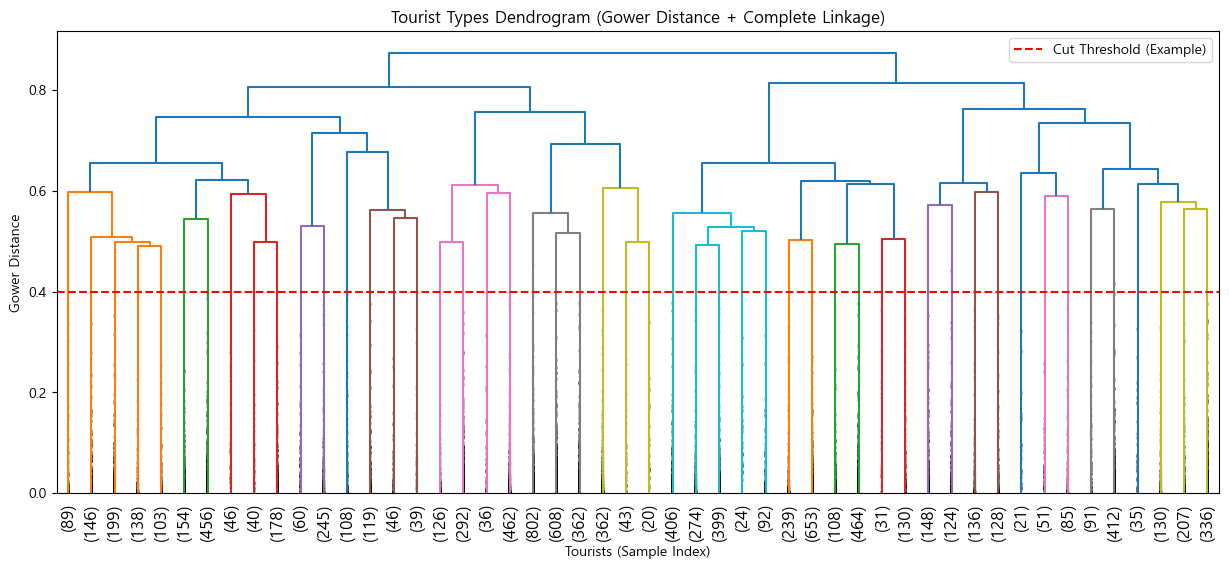

In [52]:
# 분석에 불필요한 변수 제거
cluster_data = df.drop(columns=['아이디','문1-1. 한국여행 관심 계기_1순위','문9-3. 총 체재기간_61일 이상 결측']).copy()

# # [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# # Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
# categorical_cols_int = ['성별']
# for col in categorical_cols_int:
#     cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
    #'문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z4 = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z4,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

In [53]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 6

# 군집 라벨 생성
labels4 = fcluster(Z4, k_final, criterion='maxclust')
result4 = df.copy()
result4['Cluster'] = labels4 # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    #'문9-3. 총 체재기간_61일 이상 결측': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    '연령별': get_mode,
    '한국 방문횟수(카테고리)': get_mode,
    #'문1-1. 한국여행 관심 계기_1순위': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode,
    '여행 패턴': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = result4.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = result4['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)


< 군집별 특성 요약 (k=6) >


Cluster,1,2,3,4,5,6
방문 지역 수,1.572484,1.501092,1.736914,1.24078,1.432836,1.435673
"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",321.733389,295.484257,288.589644,359.536372,305.846903,275.475168
연령별,2,2,2,2,2,2
한국 방문횟수(카테고리),1,1,1,1,1,1
문3-2. 고려한 관광인프라_1,안전 및 퀄리티,여행 편의성,여행 편의성,여행 편의성,가성비,여행 편의성
여행동반자_그룹,가족형,친구형,가족형,가족형,친구형,가족형
문3-1. 고려한 관광활동_1순위,"역사, 전통, 자연",경험형,도시 소비형,도시 소비형,특수 목적,"역사, 전통, 자연"
여행 패턴,서울 심층형,서울 심층형,서울 심층형,서울 단기형,서울 심층형,수도권/지방형(탐험가형)
Count,2166,916,2197,2820,536,1368


# 실험 5) '연령별', '총 체재기간', '한국 방문횟수' 제외

In [54]:
df.columns

Index(['아이디', '연령별', '한국 방문횟수(카테고리)', '문3-2. 고려한 관광인프라_1', '여행동반자_그룹',
       '방문 지역 수', '여행 패턴', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
       '문9-3. 총 체재기간_61일 이상 결측', '문3-1. 고려한 관광활동_1순위', '문1-1. 한국여행 관심 계기_1순위',
       'Cluster'],
      dtype='object')

< 분석 대상 변수 타입 확인 >
문3-2. 고려한 관광인프라_1                         object
여행동반자_그룹                                  object
방문 지역 수                                    int64
여행 패턴                                     object
문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)    float64
문3-1. 고려한 관광활동_1순위                        object
문1-1. 한국여행 관심 계기_1순위                      object
dtype: object
--------------------------------------------------
로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.
1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)
   -> 계산 완료. 행렬 크기: (10003, 10003)
   -> 메모리 점유율(약): 381.70 MB
2. 계층적 군집화(Linkage) 수행 중...
   -> Linkage 완료.


c:\Users\sopi0\anaconda3\envs\jjcross\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


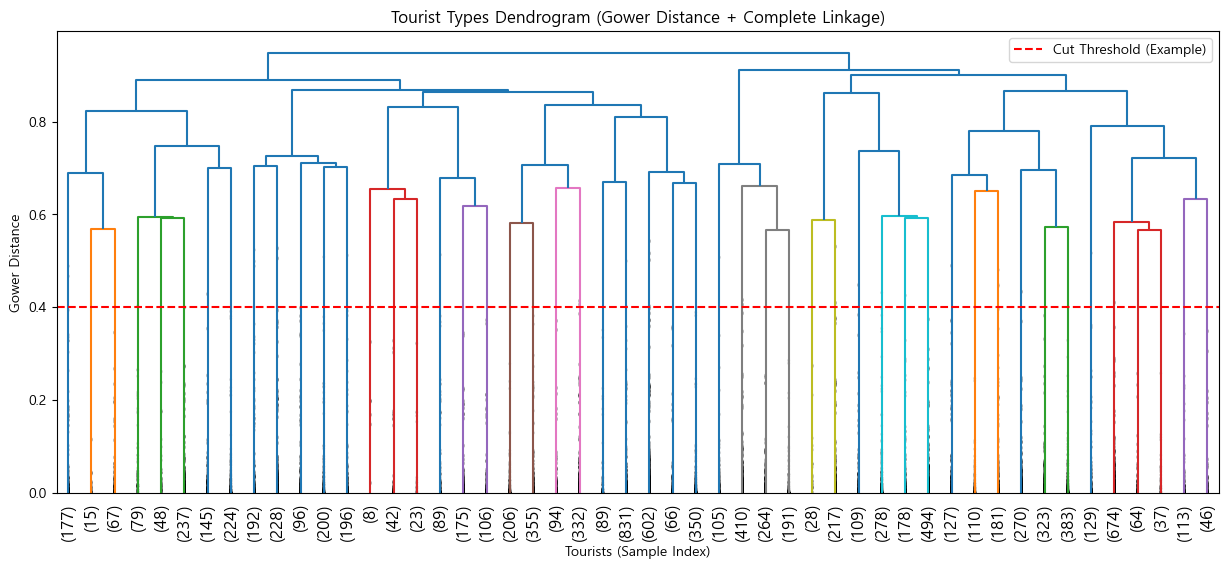

In [55]:
# 분석에 불필요한 변수 제거
cluster_data = df.drop(columns=['아이디','연령별', '한국 방문횟수(카테고리)','문9-3. 총 체재기간_61일 이상 결측', 'Cluster']).copy()

# # [중요] '숫자'로 코딩된 '범주형' 변수를 문자열로 변환
# # Gower 라이브러리가 이를 인식하고 매칭(0 or 1) 방식으로 거리를 계산하게 하기 위함입니다.
# categorical_cols_int = ['성별']
# for col in categorical_cols_int:
#     cluster_data[col] = cluster_data[col].astype(str)

print("< 분석 대상 변수 타입 확인 >")
print(cluster_data.dtypes)
print("-" * 50)

# 1. 로그 변환할 변수 (분포가 치우친 연속형 변수)
cols_to_log = [
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
    #'문9-3. 총 체재기간_61일 이상 결측'
]

# 2. 변환 적용 (log1p 사용: log(x+1)로 0값 에러 방지)
# 원본 데이터 보호를 위해 copy() 사용 권장
cluster_data_transformed = cluster_data.copy()

for col in cols_to_log:
    cluster_data_transformed[col] = np.log1p(cluster_data_transformed[col].astype(float))

# 3. 로그 변환 안 하는 변수들 (연령별, 방문횟수)은 
#    이미 int 형태로 되어 있는지(str 아님)만 확인하고 그대로 둡니다.

print("로그 변환 완료. 지출경비와 체재기간의 분포가 압축되었습니다.")

print("1. Gower 거리 행렬 계산 시작... (약 1만 건, 1~3분 소요 예상)")

# gower_matrix 함수는 컬럼 타입을 보고 자동으로 거리 계산 방식을 결정합니다.
# object/str -> Dice (같으면 0, 다르면 1)
# int/float -> Manhattan (Range로 정규화)
dist_matrix = gower.gower_matrix(cluster_data_transformed)

print(f"   -> 계산 완료. 행렬 크기: {dist_matrix.shape}")
print(f"   -> 메모리 점유율(약): {dist_matrix.nbytes / 1024 / 1024:.2f} MB")

print("2. 계층적 군집화(Linkage) 수행 중...")

# 거리 행렬을 압축된 형태(condensed form)로 변환
condensed_dist = squareform(dist_matrix)

# Linkage 수행
# method='complete': Gower 거리 사용 시 'Complete'(최장거리법) 또는 'Average'(평균거리법) 추천
# 'ward'는 유클리드 거리 기반이라 논리적으로 맞지 않음
Z5 = linkage(condensed_dist, method='complete')

print("   -> Linkage 완료.")

# 메모리 확보를 위해 거리 행렬 삭제 (선택 사항)
del dist_matrix, condensed_dist

plt.figure(figsize=(15, 6))
plt.title("Tourist Types Dendrogram (Gower Distance + Complete Linkage)")
plt.xlabel("Tourists (Sample Index)")
plt.ylabel("Gower Distance")

# 1만 개를 다 그리면 안 보이므로 상위 50개만 요약해서 시각화
dendrogram(
    Z5,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=0.4, color='r', linestyle='--', label='Cut Threshold (Example)')
plt.legend()
plt.show()

In [ ]:
# [사용자 설정] 덴드로그램을 보고 결정한 군집 수 (예: 4개)
k_final = 8

# 군집 라벨 생성
labels5 = fcluster(Z5, k_final, criterion='maxclust')
result5 = df.copy()
result5['Cluster'] = labels5 # 원본 데이터프레임에 할당

# 군집별 특성 요약 (Profiling)
def get_mode(x):
    return x.mode()[0] if not x.mode().empty else np.nan

# 분석할 변수들을 수치형과 범주형으로 나눠서 요약
agg_dict = {
    '방문 지역 수': 'mean',
    '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)': 'mean',
    #'문9-3. 총 체재기간_61일 이상 결측': 'mean',
    # 나머지 범주형 변수들은 최빈값(Mode) 확인
    #'연령별': get_mode,
    #'한국 방문횟수(카테고리)': get_mode,
    '문1-1. 한국여행 관심 계기_1순위': get_mode,
    '문3-2. 고려한 관광인프라_1': get_mode,
    '여행동반자_그룹': get_mode,
    '문3-1. 고려한 관광활동_1순위': get_mode,
    '여행 패턴': get_mode
}

# 그룹별 요약 테이블 생성
summary_df = result5.groupby('Cluster').agg(agg_dict)
summary_df['Count'] = result5['Cluster'].value_counts() # 인원 수 추가

print(f"\n< 군집별 특성 요약 (k={k_final}) >")
# 보기 좋게 전치(Transpose)하여 출력
display(summary_df.T)

NameError: name 'fcluster' is not defined

In [ ]:
reus